# ECOCLIMATE DEMO

## Setup

In [63]:
import cartopy
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import xcdat as xc
import xskillscore

from typing import Any, Dict, Union


In [2]:
REF_PERIOD= ("1980-01-01", "2020-01-01")

## xcdat, Xskillscore

In [43]:
def load_and_preprocess_data(
    fp: str = "", 
    calc_anoms: bool = False,
    regrid: bool = False,
): #-> Dict[str, Union[xr.Dataset, xr.DataArray]]:
    """
    This function will:
    1. Load an xarray dataset from the filepath fp. 
    2. Regrid the data to a 1x1 degree resolution using
    3. Calculate monthly anomalies using xcdat
    
    Arguments:
        --------------------------------
        fp (str): path and name of the file to load
        calc_anoms (bool): whether to calculate anomalies
        regrid (bool): whether to regrid the data

    Returns:
        --------------------------------
        ds (xr.Dataset): the loaded dataset 

    Raises:
        Raises an exception if the file path is invalid
    """
    # Load data
    ds_raw = xr.open_dataset(fp).drop("experimentVersionNumber").drop("realization")
    ds = ds_raw.copy()

    # Create 1 deg x 1 deg grid
    if regrid:
        lat = np.arange(-89.5, 90.5, 1)
        lon = np.arange(.5, 360.5, 1)
        output_grid = xc.create_grid(lat, lon)
        ds = ds.regridder.horizontal("t2m", output_grid, tool='xesmf', method='bilinear')

    # Calculate anomalies
    if calc_anoms:
        ds = ds.bounds.add_bounds("T")
        ds = ds.temporal.departures("t2m", "month", reference_period=REF_PERIOD)

    # Calculate regional weighted average in the Nino 3.4 region
    ds_enso = ds.sel(lat=slice(-5, 5), lon=slice(190, 240))
    ds_enso = ds_enso.bounds.add_bounds("X")
    ds_enso = ds_enso.bounds.add_bounds("Y")
    ds_enso = ds_enso.spatial.average("t2m")

    # Calculate pointwise correlation with Nino 3.4 index
    corr = xskillscore.pearson_r(ds_enso.t2m, ds.t2m)

    return ds_raw, ds, ds_enso, corr

ds_raw, ds, ds_enso, corr = load_and_preprocess_data(
    fp="/glade/work/zespinosa/Projects/Ecoclimate-sandbox/data/2mT_198001-202312_era5_global_monthly.nc",
    calc_anoms=True,
    regrid=True,
)
ds

<xarray.Dataset>
Dimensions:   (lat: 180, lon: 360, bnds: 2, time: 44)
Coordinates:
  * lat       (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon       (lon) float64 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
  * time      (time) object 1980-01-01 00:00:00 ... 2023-01-01 00:00:00
Dimensions without coordinates: bnds
Data variables:
    lat_bnds  (lat, bnds) float64 -90.0 -89.0 -89.0 -88.0 ... 89.0 89.0 90.0
    lon_bnds  (lon, bnds) float64 0.0 1.0 1.0 2.0 ... 358.0 359.0 359.0 360.0
    t2m       (time, lat, lon) float64 -1.684 -1.679 -1.674 ... 3.577 3.576
Attributes:
    Conventions:  CF-1.7
    institution:  European Centre for Medium-Range Weather Forecasts
    history:      2023-10-19T23:12 GRIB to CDM+CF via cfgrib-0.9.9.1/ecCodes-...
    source:       ECMWF

### Sanity Check

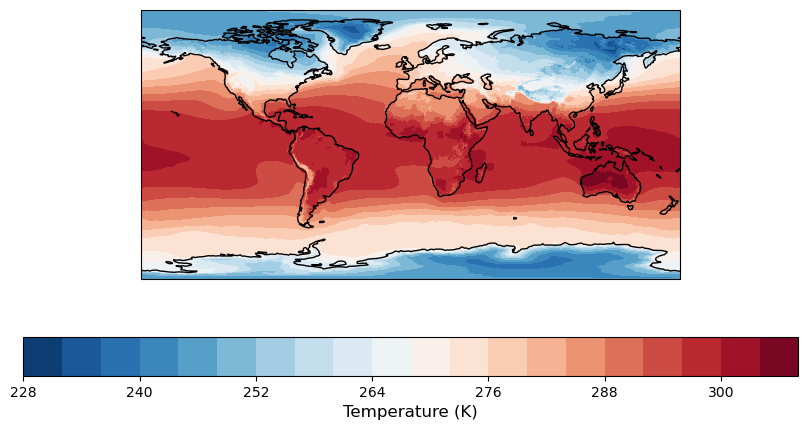

In [75]:
# Plot Climatology
fig = plt.figure(figsize=(10, 5))
ax = plt.subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.tick_params(which="both")
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
img = ax.contourf(ds_raw.lon, ds_raw.lat, ds_raw.t2m.mean("time"), transform=ccrs.PlateCarree(), cmap="RdBu_r", levels=20)
ax.coastlines()
# Add colorbar
cbar = plt.colorbar(img, ax=ax, orientation="horizontal")
# Add cbar label
cbar.set_label("Temperature (K)", fontsize=12)

([<matplotlib.axis.XTick at 0x7f46988ed490>,
 [Text(0, 0, '1980'),
  Text(5, 0, '1985'),
  Text(10, 0, '1990'),
  Text(15, 0, '1995'),
  Text(20, 0, '2000'),
  Text(25, 0, '2005'),
  Text(30, 0, '2010'),
  Text(35, 0, '2015'),
  Text(40, 0, '2020')])

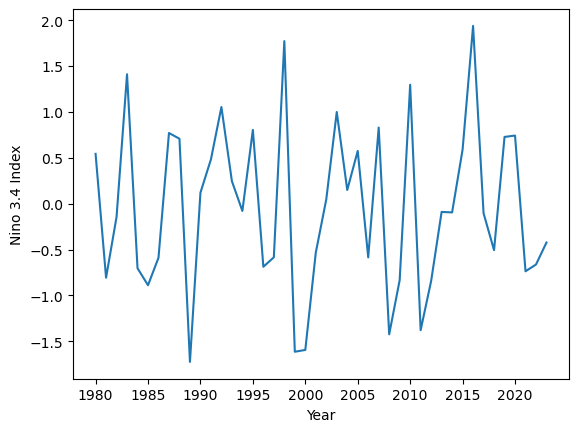

In [76]:
# Plot Nino3.4 Index
plt.plot(np.arange(len(ds_enso.time)), ds_enso.t2m.values)
plt.ylabel("Nino 3.4 Index")
plt.xlabel("Year")
plt.xticks(np.arange(0, len(ds_enso.time), 5), np.arange(1980, 2024, 5))

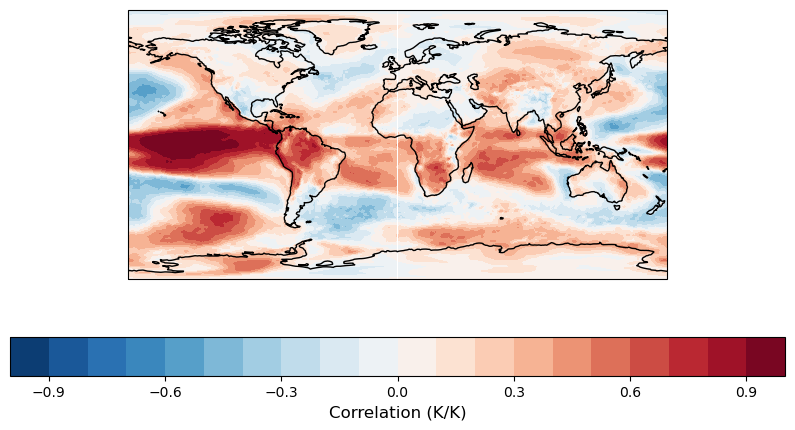

In [77]:
# Plot Correlation Map
fig = plt.figure(figsize=(10, 5))
ax = plt.subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.tick_params(which="both")
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
img = ax.contourf(corr.lon, corr.lat, corr, transform=ccrs.PlateCarree(), cmap="RdBu_r", levels=np.arange(-1, 1.1, .1))
ax.coastlines()
# Add colorbar
cbar = plt.colorbar(img, ax=ax, orientation="horizontal")
# Add cbar label
cbar.set_label("Correlation (K/K)", fontsize=12)